**Goal of the project**: To build an AI agent by using LangGraph workflow.

**Aim of the project**: To build an AI agent which will help user pack travel items based on the weather forecast.

**Import necessary packages**

In [1]:
!pip install -U langchain-community langgraph langchain-anthropic tavily-python langgraph-checkpoint-sqlite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.6
    Uninstalling langchain-text-splitters-0.3.6:
      Successfully uninstalled langchain-text-splitter

In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00


In [3]:
!apt-get update
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [69.9 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,680 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Package

In [7]:
!pip install -qU "langchain[mistralai]"

**Import necessary packages**

In [5]:
import requests
import json
import os
from collections import Counter
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.chat_models import init_chat_model
import gradio as gr
from langchain.schema import HumanMessage
from langchain.tools import tool


**Get API keys**

In [29]:
os.environ["WEATHER_API_KEY"] = "WEATHER_API_KEY"
os.environ["MISTRAL_API_KEY"] = "MISTRAL_API_KEY"

**Define the tool which fetches the weather forecast from OpenWeatherMap and gives overall summary of the weather**

In [6]:
@tool
def get_weather_summary(city: str, api_key: str) -> dict:
    """
    Fetches a 5-day weather summary for the given city using OpenWeatherMap API.

    Args:
        city: Name of the city to fetch the weather forecast for.
        api_key: OpenWeatherMap API key.

    Returns:
        dict: A dictionary containing the 5-day weather summary.
    """
    api_key = os.getenv("WEATHER_API_KEY")

    url = f"https://api.openweathermap.org/data/2.5/forecast?q={city}&units=metric&appid={api_key}"
    response = requests.get(url)
    data = response.json()

    if "list" not in data:
        return {"error": "API response does not contain forecast data."}

    daily_summary = {}

    for forecast in data["list"]:
        dt_txt = forecast["dt_txt"]
        date = dt_txt.split()[0]

        temp = forecast["main"]["temp"]
        weather_condition = forecast["weather"][0]["main"]
        rain_prob = forecast.get("pop", 0) * 100

        if date not in daily_summary:
            daily_summary[date] = {"temps": [], "conditions": [], "rain_probs": []}

        daily_summary[date]["temps"].append(temp)
        daily_summary[date]["conditions"].append(weather_condition)
        daily_summary[date]["rain_probs"].append(rain_prob)

    final_summary = {}
    all_temps = []
    all_rain_probs = []
    all_conditions = []

    for date, values in daily_summary.items():
        avg_temp = sum(values["temps"]) / len(values["temps"])
        avg_rain = sum(values["rain_probs"]) / len(values["rain_probs"])
        most_common_weather = Counter(values["conditions"]).most_common(1)[0][0]

        final_summary[date] = {
            "Avg Temp (°C)": round(avg_temp, 1),
            "Rain Chance (%)": round(avg_rain, 1),
            "Overall Weather": most_common_weather
        }

        all_temps.append(avg_temp)
        all_rain_probs.append(avg_rain)
        all_conditions.extend(values["conditions"])

    overall_avg_temp = sum(all_temps) / len(all_temps)
    overall_avg_rain = sum(all_rain_probs) / len(all_rain_probs)
    overall_weather = Counter(all_conditions).most_common(1)[0][0]

    if overall_avg_rain >= 50:
        rain_summary = "High (Frequent Rain)"
    elif overall_avg_rain >= 30:
        rain_summary = "Moderate (Occasional Rain)"
    elif overall_avg_rain >= 10:
        rain_summary = "Low (Minimal Rain)"
    else:
        rain_summary = "Very Low (Mostly Dry)"

    return {
        "city": city,
        "summary": final_summary,
        "overall_summary": {
            "Avg Temperature (°C)": round(overall_avg_temp, 1),
            "Rain Probability": rain_summary,
            "Dominant Condition": overall_weather
        }
    }


**Defining the agent state**

In [9]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

**Defining the agent workflow**

In [24]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_mistral_ai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_mistral_ai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

**Creating system prompt and initializing the chat model**

In [25]:
prompt = """You are a Travel Packing Assistant. Your task is to help users pack efficiently based on the weather at their travel destination.

Use the available tools to get overall summary of the weather before making packing recommendations. You can make multiple weather-related lookups if necessary, either together or in sequence.

Your goal is to ensure the user is well-prepared for their trip.

"""

model = init_chat_model("mistral-large-latest", model_provider="mistralai")
abot = Agent(model, [get_weather_summary], system=prompt)

**Visualizing the graph/workflow**

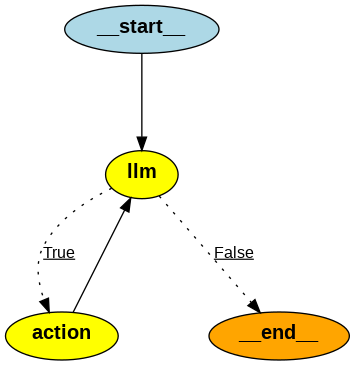

In [26]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

**Calling the agent**

In [27]:
messages = [HumanMessage(content="I am travelling to tokyo for business trip")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'get_weather_summary', 'args': {'city': 'tokyo', 'api_key': '686f2e43e705d1db14d8d51e53dadeef'}, 'id': 'xbiAp2pkv', 'type': 'tool_call'}
Back to the model!


**List of Messages**

In [28]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

I am travelling to tokyo for business trip
================================== Ai Message ==================================
Tool Calls:
  get_weather_summary (xbiAp2pkv)
 Call ID: xbiAp2pkv
  Args:
    city: tokyo
    api_key: 686f2e43e705d1db14d8d51e53dadeef
================================= Tool Message =================================
Name: get_weather_summary

{'city': 'tokyo', 'summary': {'2025-03-20': {'Avg Temp (°C)': 9.4, 'Rain Chance (%)': 0.0, 'Overall Weather': 'Clear'}, '2025-03-21': {'Avg Temp (°C)': 12.8, 'Rain Chance (%)': 0.0, 'Overall Weather': 'Clear'}, '2025-03-22': {'Avg Temp (°C)': 16.1, 'Rain Chance (%)': 0.0, 'Overall Weather': 'Clear'}, '2025-03-23': {'Avg Temp (°C)': 16.7, 'Rain Chance (%)': 0.0, 'Overall Weather': 'Clouds'}, '2025-03-24': {'Avg Temp (°C)': 14.9, 'Rain Chance (%)': 21.1, 'Overall Weather': 'Clouds'}, '2025-03-25': {'Avg Temp (°C)': 19.5, 'Rain Chance (%)': 0.0, '

**Final message**

In [31]:
print(result['messages'][-1].content)

For your business trip to Tokyo, the weather will be mostly clear and dry, with average temperatures ranging from 9°C to 19°C over the next 5 days. Here are some packing recommendations:

1. **Clothing**:
   - **Layers**: Pack layers like long-sleeved shirts, sweaters, and a light jacket to adapt to varying temperatures.
   - **Business Attire**: Include formal shirts, pants, and a suit or blazer for meetings.
   - **Casual Wear**: Pack a few casual outfits for evenings or non-business activities.

2. **Accessories**:
   - **Scarf and Gloves**: For cooler evenings.
   - **Umbrella**: Although rain is unlikely, a compact umbrella can be handy.
   - **Sunglasses**: For sunny days.

3. **Footwear**:
   - **Comfortable Shoes**: For walking around the city.
   - **Formal Shoes**: For business meetings.

4. **Toiletries**:
   - Pack your essential toiletries, and don't forget any personal medications.

5. **Electronics**:
   - **Laptop and Charger**: For work purposes.
   - **Adapter**: Japa

Based on the final message, it can be seen that agent was able to successfully suggest packing items based on the overall weather conditions.

**Conclusion**

AI agent was built with controlled workflow using LangGraph framework.